In [1]:
#COMET ML API KEY YarDlAXZLHepLKBFlSPyWbDPt
'''import comet_ml
comet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")
from comet_ml import Experiment
experiment = Experiment(
    api_key="YarDlAXZLHepLKBFlSPyWbDPt",
    project_name="asd-pytorch-atp-c",
    workspace="mattbeze",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)
hyper_params = {
    "input_size": 298,
    "hidden_size1": 100,
    "hidden_size2": 15,
    "num_layers": 4,
    "num_classes": 2,
    "batch_size": 35,
    "num_epochs": 50,
    "learning_rate": 0.01
}
experiment.log_parameters(hyper_params)'''


'import comet_ml\ncomet_ml.config.save(api_key="YarDlAXZLHepLKBFlSPyWbDPt")\nfrom comet_ml import Experiment\nexperiment = Experiment(\n    api_key="YarDlAXZLHepLKBFlSPyWbDPt",\n    project_name="asd-pytorch-atp-c",\n    workspace="mattbeze",\n    auto_metric_logging=True,\n    auto_param_logging=True,\n    auto_histogram_weight_logging=True,\n    auto_histogram_gradient_logging=True,\n    auto_histogram_activation_logging=True,\n)\nhyper_params = {\n    "input_size": 298,\n    "hidden_size1": 100,\n    "hidden_size2": 15,\n    "num_layers": 4,\n    "num_classes": 2,\n    "batch_size": 35,\n    "num_epochs": 50,\n    "learning_rate": 0.01\n}\nexperiment.log_parameters(hyper_params)'

In [2]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [3]:
Training_Data = pd.ExcelFile("Labels.xlsx") #Training Data already pre-scaled to the IBIS Data set
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Training_Data.parse(Training_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['Case','Visit','MATCH','INDEX','ASD+','ASD-','Gender'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['Final Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['CASE','MATCH','INDEX','ASD+','ASD-'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(325, 298)
(325, 1)


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)

scaled_data.shape
labels.shape

X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=0.10, random_state=seed_value)
sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.

print(X_train_smoted.shape)
print(Y_train_smoted.shape)

(484, 298)
(484, 1)


In [5]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. #Need to figure out how to get dropout
D_in, H1, H2, D_out = 298, 100, 25, 1
EPOCHS = 150
BATCH_SIZE = 35
LEARNING_RATE = 0.01

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(X_train_smoted), 
                       torch.FloatTensor(Y_train_smoted.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(X_test))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=33) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [6]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.15)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.batchnorm2 = nn.BatchNorm1d(H2)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [7]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [8]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [9]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=33)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(Y_test.values))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(Y_test.values), y_pred_list)
    ppv = precision_score(Y_test, y_pred_list, average=None)
    recall = recall_score(Y_test, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.51757 | Acc: 65.214
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 0.71021 | Acc: 79.500
Validation Accuracy |  36.36363636363637  PPV |  [1.    0.125]  Recall |  [0.3 1. ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 003: | Loss: 0.46598 | Acc: 84.357
Validation Accuracy |  87.87878787878788  PPV |  [0.90625 0.     ]  Recall |  [0.96666667 0.        ]
Training Epoch 004: | Loss: 0.33548 | Acc: 91.071
Validation Accuracy |  78.78787878787878  PPV |  [0.89655172 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 005: | Loss: 0.21282 | Acc: 93.786
Validation Accuracy |  84.84848484848484  PPV |  [0.96296296 0.33333333]  Recall |  [0.86666667 0.66666667]
Training Epoch 006: | Loss: 0.28754 | Acc: 93.786
Validation Accuracy |  87.87878787878788  PPV |  [0.90625 0.     ]  Recall |  [0.96666667 0.        ]
Training Epoch 007: | Loss: 0.26855 | Acc: 93.000
Validation Accuracy |  24.242424242424242  PPV |  [1.         0.10714286]  Recall |  [0.16666667 1.        ]
Training Epoch 008: | Loss: 0.25444 | Acc: 93.429
Validation Accuracy |  57.57575757575758  PPV |  [0.94444444 0.13333333]  Recall |  [0.56666667 0.66666667]
Training Epoch 009: | Loss: 0.19213 | Acc: 93.214
Validation Ac

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 022: | Loss: 0.11282 | Acc: 97.643
Validation Accuracy |  81.81818181818183  PPV |  [0.92857143 0.2       ]  Recall |  [0.86666667 0.33333333]
Training Epoch 023: | Loss: 0.07085 | Acc: 97.429
Validation Accuracy |  84.84848484848484  PPV |  [0.93103448 0.25      ]  Recall |  [0.9        0.33333333]
Training Epoch 024: | Loss: 0.09005 | Acc: 97.071
Validation Accuracy |  84.84848484848484  PPV |  [0.93103448 0.25      ]  Recall |  [0.9        0.33333333]
Training Epoch 025: | Loss: 0.05400 | Acc: 98.929
Validation Accuracy |  39.39393939393939  PPV |  [0.91666667 0.0952381 ]  Recall |  [0.36666667 0.66666667]
Training Epoch 026: | Loss: 0.06399 | Acc: 98.143
Validation Accuracy |  87.87878787878788  PPV |  [0.93333333 0.33333333]  Recall |  [0.93333333 0.33333333]
Training Epoch 027: | Loss: 0.03681 | Acc: 98.714
Validation Accuracy |  66.66666666666666  PPV |  [0.91304348 0.1       ]  Recall |  [0.7        0.33333333]
Training Epoch 028: | Loss: 0.04166 | Acc: 99.143
Va

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 033: | Loss: 0.03919 | Acc: 98.857
Validation Accuracy |  84.84848484848484  PPV |  [0.90322581 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 034: | Loss: 0.04174 | Acc: 98.357
Validation Accuracy |  78.78787878787878  PPV |  [0.89655172 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 035: | Loss: 0.03357 | Acc: 99.571
Validation Accuracy |  84.84848484848484  PPV |  [0.90322581 0.        ]  Recall |  [0.93333333 0.        ]
Training Epoch 036: | Loss: 0.03922 | Acc: 99.143
Validation Accuracy |  75.75757575757575  PPV |  [0.92307692 0.14285714]  Recall |  [0.8        0.33333333]
Training Epoch 037: | Loss: 0.09287 | Acc: 98.071
Validation Accuracy |  90.9090909090909  PPV |  [0.93548387 0.5       ]  Recall |  [0.96666667 0.33333333]
Training Epoch 038: | Loss: 0.07371 | Acc: 97.571
Validation Accuracy |  90.9090909090909  PPV |  [0.90909091 0.        ]  Recall |  [1. 0.]
Training Epoch 039: | Loss: 0.12785 | Acc: 98.500
Validation Accuracy 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 040: | Loss: 0.19024 | Acc: 97.000
Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]
Training Epoch 041: | Loss: 0.11390 | Acc: 96.643
Validation Accuracy |  63.63636363636363  PPV |  [0.90909091 0.09090909]  Recall |  [0.66666667 0.33333333]
Training Epoch 042: | Loss: 0.05692 | Acc: 98.500
Validation Accuracy |  75.75757575757575  PPV |  [0.92307692 0.14285714]  Recall |  [0.8        0.33333333]
Training Epoch 043: | Loss: 0.03885 | Acc: 99.357
Validation Accuracy |  72.72727272727273  PPV |  [0.92  0.125]  Recall |  [0.76666667 0.33333333]
Training Epoch 044: | Loss: 0.06595 | Acc: 98.500
Validation Accuracy |  78.78787878787878  PPV |  [0.89655172 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 045: | Loss: 0.03486 | Acc: 99.571
Validation Accuracy |  69.6969696969697  PPV |  [0.91666667 0.11111111]  Recall |  [0.73333333 0.33333333]
Training Epoch 046: | Loss: 0.05312 | Acc: 98.571
Validation Ac

Training Epoch 094: | Loss: 0.04666 | Acc: 98.929
Validation Accuracy |  75.75757575757575  PPV |  [0.89285714 0.        ]  Recall |  [0.83333333 0.        ]
Training Epoch 095: | Loss: 0.14704 | Acc: 97.500
Validation Accuracy |  72.72727272727273  PPV |  [0.92  0.125]  Recall |  [0.76666667 0.33333333]
Training Epoch 096: | Loss: 0.03186 | Acc: 98.714
Validation Accuracy |  66.66666666666666  PPV |  [0.91304348 0.1       ]  Recall |  [0.7        0.33333333]
Training Epoch 097: | Loss: 0.05131 | Acc: 98.571
Validation Accuracy |  72.72727272727273  PPV |  [0.92  0.125]  Recall |  [0.76666667 0.33333333]
Training Epoch 098: | Loss: 0.06878 | Acc: 99.143
Validation Accuracy |  63.63636363636363  PPV |  [0.90909091 0.09090909]  Recall |  [0.66666667 0.33333333]
Training Epoch 099: | Loss: 0.02764 | Acc: 99.786
Validation Accuracy |  57.57575757575758  PPV |  [0.9        0.07692308]  Recall |  [0.6        0.33333333]
Training Epoch 100: | Loss: 0.02286 | Acc: 99.571
Validation Accuracy | 

Training Epoch 147: | Loss: 0.01461 | Acc: 99.786
Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]
Training Epoch 148: | Loss: 0.00315 | Acc: 100.000
Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]
Training Epoch 149: | Loss: 0.03209 | Acc: 99.143
Validation Accuracy |  75.75757575757575  PPV |  [0.89285714 0.        ]  Recall |  [0.83333333 0.        ]
Training Epoch 150: | Loss: 0.01478 | Acc: 99.571
Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]


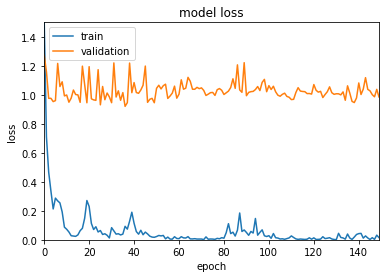

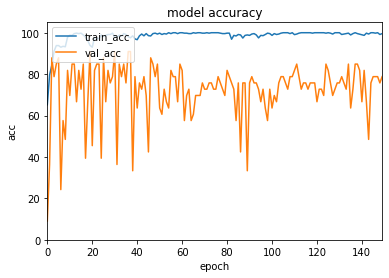

In [10]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  78.78787878787878  PPV |  [0.92592593 0.16666667]  Recall |  [0.83333333 0.33333333]


<AxesSubplot:>

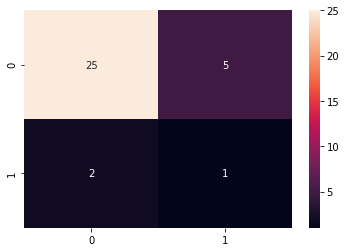

In [11]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(Y_test, y_pred_list)
ppv = precision_score(Y_test, y_pred_list, average=None)
recall = recall_score(Y_test, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(Y_test, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

In [12]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88        30
         1.0       0.17      0.33      0.22         3

    accuracy                           0.79        33
   macro avg       0.55      0.58      0.55        33
weighted avg       0.86      0.79      0.82        33



In [13]:
#Save model once everything is all figured out